# Automated Entity Recognition in Colonial Records

In this notebook, we will do take the following steps:
1. Read the data into memory and prepare it for processing
2. Setup and apply and Automated Entity Recognition pipeline
3. Assess its results

## Read and prepare the data

In [8]:
# basic imports and variables
import os

data_folder = "data/"
file_1 = "BL_IOR_E_4_24.txt" # Letters received from Bengal, Jun 1758 - Mar 1760
file_2 = "BL_IOR_B_53.txt" # Court Minutes, 8 Apr 1714 - 5 Apr 1716

In [63]:
# read raw data into memory
work_with = file_2 # or file_2

f = open(os.path.join(data_folder,work_with)).read() # f is a string

In [64]:
lines = f.splitlines() # we split the text into lines and print out the first few
lines[:20]

['BL_IOR_B_53_0001',
 'No transcript for this item',
 '',
 'BL_IOR_B_53_0002',
 'No transcript for this item',
 '',
 'BL_IOR_B_53_0003',
 'No transcript for this item',
 '',
 'BL_IOR_B_53_0004',
 '102. 3/53',
 '',
 '',
 'BL_IOR_B_53_0005',
 'Page.',
 'Appearances of Directors standing Order read',
 'I ward concerning y Owners of the Mead Frigot publishe',
 '6',
 'Algebra Suit Committee named for it',
 'Algebra Suit Old Committee to assist the New.']

We now have a list of strings containing the whole document, line by line. 
At a closer look, we note that every page is separated by the file identifier and an incremental number. We would like to use this information to create a list of pages, and remove all empty lines.

In [65]:
file_identifier = work_with.replace(".txt","")
pages = list()
new_page = ""

for n,line in enumerate(lines[1:]): # note how we start from the second line to include the first page
    if line.startswith(file_identifier):
        # append previous page to the list of pages
        pages.append(new_page.strip())
        # create a new empty page
        new_page = ""
    elif len(line) == 0 or line.startswith("No transcript for this item"): # skip empty lines or pages
        continue
    else:
        # append the line to the current page
        new_page += " "+line

In [66]:
len(pages)

686

In [67]:
# example of a single page
pages[22]

'Page- 430 Frauds discovered by Commissioners Customs 430 Frauds in Private Trade Warehouse referd- 432 Frauds proposed to be discovered by an unknown Ce Fort St. George Generall read 437 440 Francklin Richard Petition referd. 443 Factors or Writers if wanting to be sent 444. Fowler George Petition referd- 440 Fullagar John Petition. 440 Factors Petitions no more to be received till le 449 Fund at the Exchequer Receipts by whom to belie Francet Thomas letter be referd. 451 19.3 Ditto. 2 454 Forfeitures of The Directors not allowed the Hospitall Fractors Red to contribute to the Hospitall- 4. Free Merchants to contribute to the Hospitall 4 5 Ferrey Anne Petition referd. 466 Forter Samuell Goods deliverd paying be Farmer Richard Tea delivered paying ec 76 Foster Nathaniel Claim on his Pages referd Fenwick M. Edward elected Chief Supra cargo offe 170 Frankland St. Thomas for the Intereston R. Staines Ace: 109 3 404 Fenwick Edward goods to be delivered paying Ce 406 Fenwick E. to have 1: 1

We have now turned our raw dataset into a list of pages, each containing its automatically recognised text. 

You may want to take a moment to inspect several pages and compare them with the document images. You will notice that, despite a good overall quality, automatic text recognition is never without errors: these will also have an impact when doing entity recognition.

We now turn or attention to the entity recognition pipeline.

---

## Automated Entity Recognition

Automatic Entity Recognition, often also called *Named Entity Recognition* or just *Entity Recognition*, is a popular step in Natural Language Processing (NLP) pipelines. Its goal is to find mentions of entities of interest, and their type. The most popular entity types are person, place and organisation. An NLP pipeline is usually comprised of several sequential steps, as illustrated here:  

<img src="resources/spacy_ner_pipeline.png" alt="spacy ner pipeline" />

From an input text, for example in page of our documents, an NLP pipeline has to deal with tokenisation (splitting a text into constituent parts, for example words), lemmatising (transforming a word into its base lemma), tagging (detecting the part of speech of a word), parsing (detecting the syntactic structure of a sentence), and more. Entity recognition therefore is but one step into an NLP pipeline.

In what follows, we will rely on the spaCy library, a popular natural language toolkit in Python. For more details of the model we will use, see https://spacy.io/models/en. Firstly, we will load the library and trained model, we will then see an example and apply a basic AER pipeline to our documents.

In [68]:
#!python -m spacy download en_core_web_sm # execute this only once. en_core_web_sm is a small model trained for English

In [69]:
import spacy

texts = [
    "The New York Times is a newspaper based in New York.",
    "We will be able to go to Mars by 2035. Will you go?",
]

nlp = spacy.load("en_core_web_sm")
for doc in nlp.pipe(texts, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"], n_process=-1):
    print([(ent.text, ent.label_) for ent in doc.ents])

[('The New York Times', 'ORG'), ('New York', 'GPE')]
[('Mars', 'LOC'), ('2035', 'DATE')]


In [70]:
# apply on our data, this might take a while

entities = list()
for doc in nlp.pipe(pages, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"], n_process=-1):
    entities.extend([(ent.text, ent.label_) for ent in doc.ents])

In [71]:
len(entities) # we have found many entity mentions! 

49921

In [72]:
print(entities[:10])

[('102', 'CARDINAL'), ('3/53', 'CARDINAL'), ('Order', 'ORG'), ('Algebra Suit Old Committee', 'ORG'), ('Albans', 'NORP'), ('10', 'CARDINAL'), ('500', 'CARDINAL'), ('12', 'CARDINAL'), ('Committee', 'ORG'), ('13', 'CARDINAL')]


In [73]:
# you can use this command to get an explanation of types
spacy.explain("NORP")

'Nationalities or religious or political groups'

Note that we use a trained model which works with a fixed set of types. An important question when dealing with AER is **which typology to use** (i.e., set of types). Often, historical records require bespoke typologies to capture their rich contents.

---

## Results

Let us now take a look at the results we got. Firstly, we will create a *data frame* to more easily manipulate the data. Secondly, we will check which are the most frequent mentions. Lastly, we will create a visualisation to see the distribution of mentions by entity. We will conclude by discussing the limitations of these results, and how to proceed to evaluate their quality more rigorously.

In [74]:
# create a data frame
import pandas as pd

df = pd.DataFrame(entities, columns=["mention","type"])

In [75]:
df.head()

,mention,type
0,102,CARDINAL
1,3/53,CARDINAL
2,Order,ORG
3,Algebra Suit Old Committee,ORG
4,Albans,NORP


In [76]:
df_sorted = df.groupby(["mention","type"]).size().reset_index(name='counts').sort_values('counts', ascending=False)

In [77]:
df_sorted.head(10)

,mention,type,counts
13,0,CARDINAL,2138
4291,Court,ORG,1064
77,1,CARDINAL,413
132,10,CARDINAL,400
592,2,CARDINAL,310
1726,6,CARDINAL,293
15244,Treasury,ORG,277
1242,4,CARDINAL,264
3134,Bombay,GPE,259
18514,two,CARDINAL,252


In [78]:
df_sorted[df_sorted["type"]!="CARDINAL"].head(10)

,mention,type,counts
4291,Court,ORG,1064
15244,Treasury,ORG,277
3134,Bombay,GPE,259
12698,Ships,ORG,187
7433,John Browne,PERSON,169
11885,Robert Brisco,PERSON,166
2147,Accompt,NORP,154
6167,Goods,LOC,130
8592,Letter,NORP,129
2988,Bill,PERSON,122


In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

In [80]:
df_sorted_types = df_sorted[["type","counts"]].groupby(["type"]).agg(sum).reset_index().sort_values('counts', ascending=False)

In [81]:
df_sorted_types

,type,counts
13,PERSON,16593
0,CARDINAL,13136
11,ORG,10603
1,DATE,2304
4,GPE,2074
9,NORP,869
17,WORK_OF_ART,824
8,MONEY,684
14,PRODUCT,569
7,LOC,542


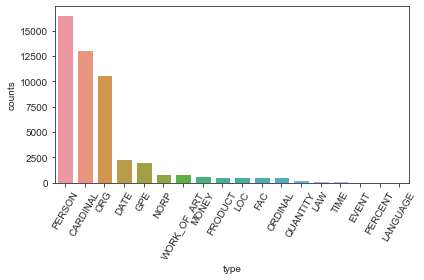

In [82]:
sns.barplot(df_sorted_types, x="type", y="counts")
#g.set_xticklabels(g.get_xticklabels(), rotation=45)
plt.xticks(rotation=60)
plt.tight_layout()

A good exercise is to replicate our results using the other documents we provide, and compare their results. Do they often mention the same entities? Is the overall distribution the same, or different? Can you suggest why?

---

## What is next

What we have seen here is the tip of the iceberg. The most promising next steps would include:
- the creation of an annotated dataset in order to evaluate AER models, and train new ones.
- Using more powerful methods, which will likely yield better results.

More importantly, can you think of how we might use newly detected entities for information retrieval or research?

---